<a href="https://colab.research.google.com/github/lauragoon/Face-Mask-Detector/blob/main/knn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Reshape
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
def get_data(batch_size, directory):
  
  datagen = image.ImageDataGenerator()
  dta = datagen.flow_from_directory(directory, class_mode='binary', batch_size=batch_size)

  return dta

In [ ]:
def knn(model, output_size):
    vector = np.prod(model.output_shape[1:])
    x = Reshape(target_shape=(vector,))(model.output)
    x = Dense(units=output_size, activation='linear', use_bias=False)(x)             
    knn_model = Model(inputs=[model.input], outputs=x)
    return knn_model

In [ ]:
def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=0)
    return vectors / norms

In [ ]:
def model_accuracy(k, model, test_batch_images, test_batch_class, train_batch_class):
  weighted_pred = []
  majority_pred = []
  difference = 0
  for i in test_batch_images:
      im = np.expand_dims(i, axis=0)
      im = preprocess_input(im)
      result = joined_model.predict([im]).reshape(-1)
      result_idx = result.argsort()[-k:][::-1]
      
      ### distance-weighted voting      
      w0 = 0
      w1 = 0
      for i in result_idx:
        if train_batch_class[i] == 0:
          w0 += (1/result[i])
        else:
          w1 += (1/result[i])
      if w0 > w1:
        weighted_pred.append([0])
        check = 0
      else:
        weighted_pred.append([1])
        check = 1

      ### simple majority voting
      result_class = []
      for j in result_idx:
        result_class.append(train_batch_class[j])
      sum_result = round(sum(result_class) / k)
      majority_pred.append(sum_result)

      if sum_result != check:
        difference += 1

  print('different predictions between simple majority voting and distance-weighted voting: ', difference)

  weighted_acc = 0
  for i in range(len(test_batch_class)):
    if weighted_pred[i] == test_batch_class[i]:
      weighted_acc += 1
  
  majority_acc = 0
  for i in range(len(test_batch_class)):
    if majority_pred[i] == test_batch_class[i]:
      majority_acc += 1
  print('simple majority voting accuracy: ', majority_acc/len(test_batch_class))
  print('distance-weighted voting accuracy: ', weighted_acc/len(test_batch_class))

  return weighted_acc/len(test_batch_class)

Found 1012 images belonging to 2 classes.
finished generating batches
finished feature extraction
built model
different predictions between simple majority voting and distance-weighted voting:  0
simple majority voting accuracy:  0.978
distance-weighted voting accuracy:  0.978
plot k= 3
different predictions between simple majority voting and distance-weighted voting:  0
simple majority voting accuracy:  0.978
distance-weighted voting accuracy:  0.978
plot k= 5
different predictions between simple majority voting and distance-weighted voting:  0
simple majority voting accuracy:  0.928
distance-weighted voting accuracy:  0.928
plot k= 7
different predictions between simple majority voting and distance-weighted voting:  0
simple majority voting accuracy:  0.598
distance-weighted voting accuracy:  0.598
plot k= 9
different predictions between simple majority voting and distance-weighted voting:  0
simple majority voting accuracy:  0.338
distance-weighted voting accuracy:  0.338
plot k= 11

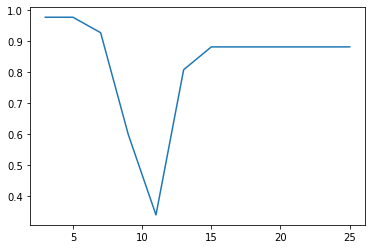

In [ ]:
## generate data
train_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/training'
test_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/test'

# train_data = get_data(2000, train_path)
test_data = get_data(500, test_path)

train_batch_images, train_batch_class = train_data.next()
test_batch_images, test_batch_class = test_data.next()

print('finished generating batches')

## pre-trained neural network to extract features
nn_model = ResNet50(input_shape=(256,256,3),
                    weights='imagenet',
                    include_top=False,
                    pooling='avg')

## feature extraction
img_features = nn_model.predict(train_batch_images).T

print('finished feature extraction')

## create knn model
joined_model = knn(nn_model, img_features.shape[1])

## normalize features
norm_img_features = normalize_vectors(img_features)
tSNE = TSNE().fit_transform(norm_img_features.T)
df = pd.DataFrame(tSNE)

## set model weights
weights = joined_model.get_weights()
weights[-1] = norm_img_features
joined_model.set_weights(weights)

print('built model')

# graph k vs accuracy
x = [2*i+3 for i in range(12)]
y = []

for k in x:
  y.append(model_accuracy(k, joined_model, test_batch_images, test_batch_class, train_batch_class))
  print('plot k=', k)

plt.plot(x,y)



In [ ]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=train_batch_class)

In [ ]:
## choose k=3
y

In [ ]:
## references: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c, https://github.com/sorenlind/keras-knn/blob/master/keras-knn.ipynb, 

In [11]:
joined_model.save('knn.h5')